In [ ]:
#importer les ficher non accessibles localement

from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import os
from os.path import normpath
from pathlib import PureWindowsPath
import numpy as np


def convert(path):
    return PureWindowsPath(normpath(PureWindowsPath(path).as_posix())).as_posix()


chemin_du_fichier = convert("train_xl.jsonl")
df = pd.read_json(chemin_du_fichier , lines=True)
print(df.head())

l_option1 = list(df["option1"])
l_option2 = list(df["option2"])




def frequency1(l):
    counter = Counter(l)
    # Trie les mots par fréquence décroissante
    sorted_words = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    sorted_words = [[word, freq] for word, freq in sorted_words]
    for i in range(len(sorted_words)):
        sorted_words[i][1] /= 2

    return sorted_words

def frequency2(l):
    counter = Counter(l)
    # Trie les mots par fréquence décroissante
    sorted_words = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    sorted_words = [[word, freq] for word, freq in sorted_words]

    return sorted_words

def frequency3(l):
    counter = Counter(l)
    # Trie les mots par fréquence décroissante
    sorted_words = sorted(counter.items(), key=lambda x: x[1], reverse=True)

    sorted_words = [[word, freq] for word, freq in sorted_words]
    unsorted_words = {word:freq for word, freq in sorted_words}
    return sorted_words, unsorted_words

words_and_occurences_sorted_option1 = frequency1(l_option1)
#common_words_and_occurences_sorted_option1
words_and_occurences_sorted_option2 = frequency1(l_option2)

# def common_words_only(l_sorted_occurences):
#     for line in l_sorted_occurences:
#         if line

                                qID  \
0  3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-2   
1  3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-1   
2  3XWUWJ18TLO2DDRXF83QWLKRJ29UU4-1   
3  3XWUWJ18TLO2DDRXF83QWLKRJ29UU4-2   
4  3D5G8J4N5CI2K40F4RZLF9OG2CKVTH-2   

                                            sentence option1 option2  answer  
0  Ian volunteered to eat Dennis's menudo after a...     Ian  Dennis       2  
1  Ian volunteered to eat Dennis's menudo after a...     Ian  Dennis       1  
2  He never comes to my home, but I always go to ...    home   house       1  
3  He never comes to my home, but I always go to ...    home   house       2  
4  Kyle doesn't wear leg warmers to bed, while Lo...    Kyle   Logan       2  


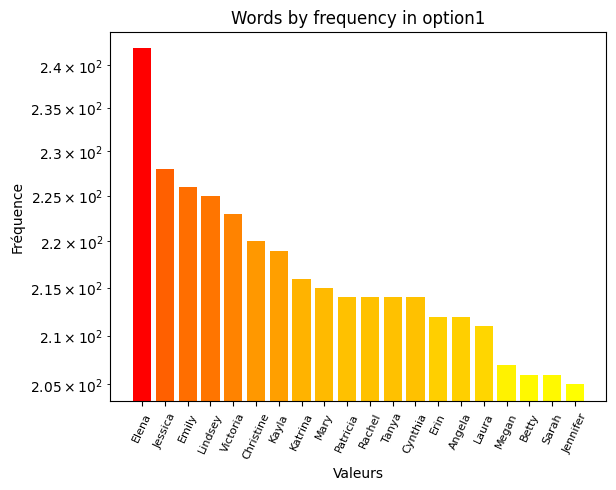

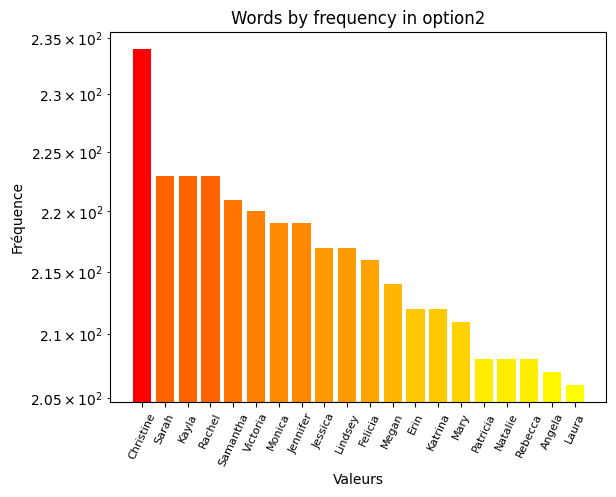

In [ ]:
from matplotlib import colors

def frequency_plot(x,y,plot_name):
# Créer un colormap allant du rouge au bleu
    cmap = colors.LinearSegmentedColormap.from_list("red_to_blue", ["yellow", "red"])

# Normaliser les fréquences entre 0 et 1 pour les appliquer au colormap
    norm = plt.Normalize(min(y), max(y))

# Créer une figure et un axe
    fig, ax = plt.subplots()

# Dessiner l'histogramme avec un dégradé de couleur
    for i in range(len(x)):
        ax.bar(x[i], y[i], width=0.8, color=cmap(norm(y[i])), align='center')

    ax.set_yscale('log')
# Titres et labels
    plt.title(plot_name)
    plt.xlabel("Valeurs")
    plt.ylabel("Fréquence")
    plt.xticks(rotation=65)
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.show()

def frequency_COCAvsWINOGRANDE(x,y,plot_name):
# Créer un colormap allant du rouge au bleu
    cmap = colors.LinearSegmentedColormap.from_list("red_to_blue", ["yellow", "red"])

# Normaliser les fréquences entre 0 et 1 pour les appliquer au colormap
    norm = plt.Normalize(min(y), max(y))

# Créer une figure et un axe
    fig, ax = plt.subplots()

# Dessiner l'histogramme avec un dégradé de couleur
    for i in range(len(x)):
        ax.bar(x[i], y[i], width=0.8, color=cmap(norm(y[i])), align='center')
    x = np.arange(0, 26)
    plt.plot(x, x, color='green', linewidth=2, label="f(x) = x")

# Titres et labels
    plt.title(plot_name)
    plt.xlabel("COCA frequency rank")
    plt.ylabel("Winogrande frequency rank")
    plt.xticks(rotation=65)
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.legend(loc='upper left')
    plt.show()

def frequency_plot_linear(x,y,plot_name):
# Créer un colormap allant du rouge au bleu
    cmap = colors.LinearSegmentedColormap.from_list("red_to_blue", ["yellow", "red"])

# Normaliser les fréquences entre 0 et 1 pour les appliquer au colormap
    norm = plt.Normalize(min(y), max(y))

# Créer une figure et un axe
    fig, ax = plt.subplots(figsize=(12, 6))

# Dessiner l'histogramme avec un dégradé de couleur
    for i in range(len(x)):
        ax.bar(x[i], y[i], width=0.8, color=cmap(norm(y[i])), align='center')

    ax.set_yscale('linear')
# Titres et labels
    plt.title(plot_name)
    plt.xlabel("Valeurs")
    plt.ylabel("Fréquence")
    plt.xticks(rotation=65)
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.show()

def frequency_plot_log_likelihood(x,y,plot_name):
# Créer un colormap allant du rouge au bleu
    cmap = colors.LinearSegmentedColormap.from_list("red_to_blue", ["yellow", "red"])

# Normaliser les fréquences entre 0 et 1 pour les appliquer au colormap
    norm = plt.Normalize(min(y), max(y))
    plt.figure(figsize=(10, 6))
# Créer une figure et un axe
    fig, ax = plt.subplots()

# Dessiner l'histogramme avec un dégradé de couleur
    for i in range(len(x)):
        ax.bar(x[i], y[i], width=0.8, color=cmap(norm(y[i])), align='center')

    ax.set_yscale('log')
# Titres et labels
    plt.title(plot_name)
    plt.xlabel("Words (sorted by frequency rank in Winogrande)")
    plt.ylabel("Log-likelihood score")
    plt.xticks(rotation=65)
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.show()

plot_name = "Words by frequency in option1"
x1 = [row[0] for row in words_and_occurences_sorted_option1]
y1 = [row[1] for row in words_and_occurences_sorted_option1]
frequency_plot(x1[:20],y1[:20],plot_name)

plot_name = "Words by frequency in option2"
x2 = [row[0] for row in words_and_occurences_sorted_option2]
y2 = [row[1] for row in words_and_occurences_sorted_option2]
frequency_plot(x2[:20],y2[:20],plot_name)



<ipython-input-51-924689527>:6: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-lambda_ * x) + 1
<ipython-input-51-924689527>:6: RuntimeWarning: overflow encountered in multiply
  return A * np.exp(-lambda_ * x) + 1


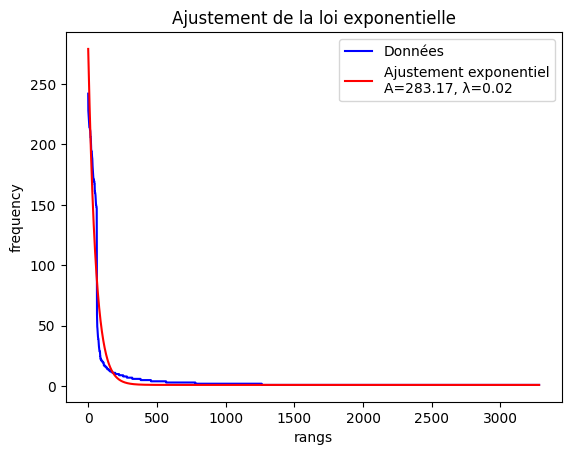

R² : 0.9381
Paramètre estimé A : 283.17
Paramètre estimé lambda : 0.02


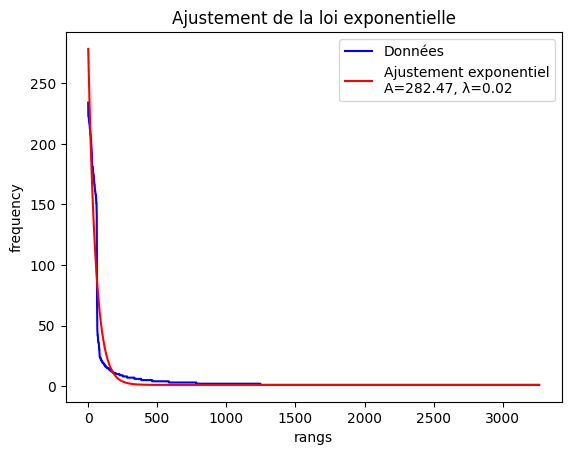

R² : 0.9356
Paramètre estimé A : 282.47
Paramètre estimé lambda : 0.02


In [ ]:
from scipy.optimize import curve_fit


# Définir la fonction exponentielle pour l'ajustement
def exp_func(x, A, lambda_):
    return A * np.exp(-lambda_ * x) + 1

def exp_model_and_plot(x_values,y_values):
    # Ajuster la fonction exponentielle aux données
    rangs = np.arange(1, len(x_values) + 1)
    params, covariance = curve_fit(exp_func, rangs, y_values, p0=[1, 0.1])

# Extraire les paramètres ajustés A et lambda
    A_estime = 8
    A_estime, lambda_estime = params


# Générer les valeurs ajustées
    x_fit = np.linspace(min(rangs), max(rangs), len(x_values))
    y_fit = exp_func(x_fit, *params)

# Visualiser les données et l'ajustement
    plt.plot(rangs, y_values, label="Données", color="blue")
    plt.plot(x_fit, y_fit, label=f"Ajustement exponentiel\nA={A_estime:.2f}, λ={lambda_estime:.2f}", color="red")
    plt.xlabel('rangs')
    plt.ylabel('frequency')
    plt.legend()
    plt.title('Ajustement de la loi exponentielle')
    plt.show()

    residus = y_values - y_fit

# Somme totale des carrés (variance des valeurs réelles autour de leur moyenne)
    SS_tot = np.sum((y_values - np.mean(y_values))**2)

# Somme des carrés des résidus
    SS_res = np.sum(residus**2)

# Coefficient de détermination R²
    R_squared = 1 - (SS_res / SS_tot)

# Affichage du résultat
    print(f"R² : {R_squared:.4f}")
    print(f"Paramètre estimé A : {A_estime:.2f}")
    print(f"Paramètre estimé lambda : {lambda_estime:.2f}")

exp_model_and_plot(x1,y1)
exp_model_and_plot(x2,y2)

In [ ]:
import spacy
from tqdm import tqdm

def cross_frequency(df):
    nlp = spacy.load("en_core_web_sm")
    pairs = []
    for index, row in tqdm(df.iterrows(),total = len(df)):
        if row.values[4] == 1:
            option = 2
        else:
            option = 3

        if nlp(row.values[option])[0].pos_ == 'PROPN':
            for word in row.values[1].split():
                pairs += [(row.values[option],word)]
        else:
            for word in row.values[1].split():
                pairs += [(row.values[option],word)]
    return frequency2(pairs)

# cross_frequency(df)


def link_with_adj(df):
    adj_pairs = []
    pairs = cross_frequency(df)
    nlp = spacy.load("en_core_web_sm")
    for pair in pairs:
        word_sentence = nlp(pair[0][1])
        if word_sentence[0].pos_ == "ADJ":
            adj_pairs += pair
            print(pair)

def link_with_verbs(df):
    adj_pairs = []
    pairs = cross_frequency(df)
    nlp = spacy.load("en_core_web_sm")
    for pair in pairs:
        word_sentence = nlp(pair[0][1])
        if word_sentence[0].pos_ == "VERB":
            adj_pairs += pair
            print(pair)

# link_with_adj(df)


/usr/local/lib/python3.11/dist-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/usr/local/lib/python3.11/dist-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string


# Compare the word distribution of the dataframe with a classic distribution

In [ ]:
from tqdm import tqdm
# Create a list of frequences for dt words
def frequency_list(df):
    tot_word_list = []
    for index, row in tqdm(df.iterrows(),total = len(df)):
        for word in row.values[1].split():
                if not (word == '_' or word[0].isupper()):
                    tot_word_list.append(word)
    return *frequency3(tot_word_list), len(tot_word_list)

frequency_list_df1, dict_frequency_list_df1, size_frequency_list_df1 = frequency_list(df)

100%|██████████| 40398/40398 [00:02<00:00, 16372.98it/s]


récupérer les 2 fréquences relatives : cacluler la diff normalisée par la fréquence du corpus de référécen
    on s'attend à une distribution en cloche
    
faire la méthode de vraissemblance que si la fréquence des mots (nb) est suffisament grande
plus le log est grand, plus
=> le seuil de fréquence minimal est de 5 => on ne calcule pas leurs valeurs

fonction de calcul de spécificité
TXM, i tramer, ...

In [ ]:
# we import data from COCA :

# Charger le fichier Excel
df2 = pd.read_excel("wordFrequency.xlsx", sheet_name="4 forms (219k)")  # Remplace avec le vrai nom du fichier et de la feuille

# Sélectionner deux colonnes
frequency_list_df2 = df2[["word", "freq"]].values.tolist()
frequency_list_df2_rank = df2[["word", "rank"]].values.tolist()
size_frequency_list_df2 = 50033612/0.05

my_dict_coca = {key:value for key,value in frequency_list_df2 }
my_dict_coca2 = {key:value for key,value in frequency_list_df2_rank }



FileNotFoundError: [Errno 2] No such file or directory: 'wordFrequency.xlsx'

In [ ]:
plot_name = "Words by frequency in Winogrande"
x1 = [row[0] for row in frequency_list_df1]
y1 = [row[1] for row in frequency_list_df1]
frequency_plot(x1[:20],y1[:20],plot_name)
print(size_frequency_list_df1)
plot_name = "Words by frequency in COCA"
x1 = [row[0] for row in frequency_list_df2]
y1 = [row[1] for row in frequency_list_df2]
frequency_plot(x1[:20],y1[:20],plot_name)

In [ ]:
plot_name = "Words by frequency in Winogrande"
x1 = [row[0] for row in frequency_list_df1]
y1 = [row[1] for row in frequency_list_df1]
frequency_plot(x1[:20],y1[:20],plot_name)

plot_name = "Words by frequency in COCA"
y1 = [my_dict_coca[key] if key in my_dict_coca else 0 for key in x1  ]
frequency_plot(x1[:20],y1[:20],plot_name)

plot_name = "Frequency rank comparison between Winogrande and COCA"
y1 = [my_dict_coca2[key] if key in my_dict_coca2 else 0 for key in x1  ]
frequency_COCAvsWINOGRANDE(x1[:25],y1[:25],plot_name)

In [ ]:
# on fait la méthode du log vraissemblance :
import math

def log_likelihood(a,b,c,d):
    E1 = c*(a+b)/(c+d)
    E2 = d*(a+b)/(c+d)
    return 2*(a*math.log(a/E1) + b*math.log(b/E2))

# we calculate for each word :
def log_for_40_values(frequency_list_df1, my_dict_coca,size_frequency_list_df1,size_frequency_list_df2):
    list_likelihood = []
    i = 0
    while frequency_list_df1[i][1] >= 10:
        if frequency_list_df1[i][0] in  my_dict_coca:
            a,b,c,d = frequency_list_df1[i][1],my_dict_coca[frequency_list_df1[i][0]],size_frequency_list_df1,size_frequency_list_df2
            if a/c > b/d:
                list_likelihood.append((frequency_list_df1[i][0],log_likelihood(a,b,c,d)))

#             if frequency_list_df1[i][0] == 'i':
#                 print("_________")
#             print("frequency list df1 i :", frequency_list_df1[i][0], frequency_list_df1[i][1], my_dict_coca[frequency_list_df1[i][0]],size_frequency_list_df1,size_frequency_list_df2, list_likelihood[-1][-1], sep = '\t')

        i += 1
    return list_likelihood

list_likelihood = log_for_40_values(frequency_list_df1,my_dict_coca,size_frequency_list_df1, size_frequency_list_df2)

L = sorted(list_likelihood,key = lambda x: x[1], reverse = True)


In [ ]:
plot_name = "Log-likelihood analysis : Winogrande vs COCA"
x1 = [row[0] for row in L]
y1 = [row[1] for row in L]
frequency_plot_log_likelihood(x1[:20],y1[:20],plot_name)

connecteurs discursifs
(lien entre les phrases)

appoline
arbres de parsing
fonctions syntaxiques

bcp de phrases ont à la fois but et because
=> analyser les connecteurs qui sont fréquement ensembles
éventuellemnt regarder les triplet et lier aux schémas (afficher les phrases)

bcp de schéma : pb de conteneur/contenant
classifieur qui détermine si un pb est de ce type (fitting problem)
90% de certitude
si on prive un modèle de ce type de pb, quel serait le succès
on fait notre problème fine tunning, modèle de sagaguchi

les prénons d'hommes et de femmes ne sont pas associés aux même schémas (s'entrainer = masculin, demander conseil = féminin)
quasi exclusivité

but = legitimer la négation

In [ ]:
def cooccurrence(w1, w2):
    counter = 0
    for sentence in df["sentence"] :
        s = sentence.split()
        if w1 != w2 :
            if w1 in s and w2 in s :
                counter +=1
        else:
            if sentence.count(w1) >= 2:
                counter += 1
    return counter

def occurrence(w):
    counter = 0
    for sentence in df["sentence"] :
        s = sentence.split()
        if w in s :
            counter +=1
    return counter

n = 20
co_matrix = np.zeros((n, n), dtype=int)
nb_sentences = len(df["sentence"])

a = 0.1

for i in tqdm(range(20)):
    for j in range(20):
        co_matrix[i][j] = cooccurrence(L[i][0],L[j][0])
        # co_matrix[i][j] = (co_matrix[i][j] + a) / (nb_sentences +  a * len(frequency_list_df1))



n = 20
co_matrix_diag = np.zeros((n, n), dtype=int)

for i in range(20):
        co_matrix_diag[i][i] = occurrence(L[i][0])



# co_matrix = co_matrix / nb_sentences
co_matrix_diag = co_matrix_diag / nb_sentences


faire le PMI avec les 20 mots mais avec tous les autres mots qui ne sont pas nécessairement dans cette liste
faire avec les mots qui ont une fréquence minimale
prendre les valeurs extrêmes (2 et -2)

fin tunning sur le winogrande
voir comment le score évolue en fonction des données qu'on lui donne
faire des phrases :
- interchenger des mots qui ont une faible association
aurélien/appoline : représentaiton par des graphes

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels = L[:20]
labels = [x[0] for x in labels]

plt.figure(figsize=(15, 8))
sns.heatmap(co_matrix, annot=True, fmt=".0f", cmap="Blues",xticklabels= labels, yticklabels= labels)
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=45)
plt.title("Cooccurrence table")


# labels = L[:20]
# labels = [x[0] for x in labels]

# plt.figure(figsize=(15, 8))
# sns.heatmap(co_matrix_diag, annot=True, fmt="0.2f", cmap="Blues",xticklabels= labels, yticklabels= labels)
# plt.gca().xaxis.set_ticks_position('top')
# plt.xticks(rotation=45)
# plt.title("Frequency table")

# plt.show()


In [ ]:
# Pointwise mutal information
import math
n = 20

PMI_matrix = np.zeros_like(co_matrix, dtype=float)


for i in range(20):
    for j in range(20):
        if co_matrix[i][j] == 0 or  co_matrix_diag[j][j] * co_matrix_diag[i][i] == 0:
            PMI_matrix[i][j] = float('-inf')
        else:
            PMI_matrix[i][j] = math.log(co_matrix[i][j]/(co_matrix_diag[j][j]*co_matrix_diag[i][i]))
# print(PMI_matrix)

In [ ]:
labels = L[:20]
labels = [x[0] for x in labels]
finite_mask = np.isfinite(PMI_matrix)
max_val = np.max(np.abs(PMI_matrix[finite_mask]))


plt.figure(figsize=(15, 8))
sns.heatmap(PMI_matrix, annot=True, fmt="0.1f",vmin=-max_val, vmax=max_val, cmap="coolwarm",xticklabels= labels, yticklabels= labels)
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=45)
plt.title("Pointwise mutal information analysis")

plt.show()

schémas :
- comparaison

marc and peter were friends, but unlike marc, peter was really into sport, thus he often/never goes to matchs

In [ ]:
male_names = [
    'Ian', 'Dennis', 'Kyle', 'Logan', 'Craig', 'Derrick', 'Robert', 'Donald', 'Leslie', 'William', 'Neil',
    'Kenneth', 'Eric', 'Kevin', 'Jason', 'Benjamin', 'Joseph', 'John', 'Aaron', 'Nick', 'Adam', 'Matthew',
    'Justin', 'Michael', 'Joel', 'Christopher', 'Steven', 'Brett', 'Jeffrey', 'Jim', 'Byron', 'Brian', 'Samuel',
    'Cricket', 'Jack', 'Lawrence', 'Randy', 'Ryan', 'Avid', 'Bill', 'Bob', 'Hunter', 'Jordan', 'Jay', 'Jeremy',
    'George', 'Ricky', 'Jake', 'David', 'Patrick', 'Joe', 'Don', 'Ken', 'Kenny', 'G', 'Mike', 'California',
    'Shane', 'Josh', 'Tim', 'Earl', 'Kim', 'Casper', 'Josh', 'Tim', 'Jay', 'Jeremy', 'Gavin', 'Samsung', 'Master',
    'Jay', 'Jeremy', 'David', 'Peter', 'Kendall', 'Jacob', 'Josh', 'Tim', 'Gordon', 'Daniel', 'Potato', 'Max',
    'Matt', 'Tim', 'Ken', 'Kevin', 'Joseph', 'Paul', 'George', 'Jeremy', 'Joseph', 'Brian', 'Nick', 'Nick', 'Ken',
    'Jake', 'Steve', 'Tom', 'Frank', 'Mike', 'Peter', 'Henry', 'Larry', 'John', 'James', 'Kyle', 'Tim', 'Michael',
    'Dave', 'Matt', 'Ben', 'Dustin', 'Oliver', 'Matt', 'Andy', 'Pete', 'Jake', 'Aaron', 'Brennan', 'Jason', 'James',
    'Thomas', 'Charles', 'Richard', 'Walter', 'Barry', 'Tom', 'Greg', 'Jerry', 'Mark', 'Johnny', 'Todd', 'Bobby',
    'Joe', 'Daniel', 'Sam', 'Chris', 'Josh', 'Will', 'Timothy', 'Samuel', 'Jack', 'Dustin', 'Johnny', 'Peter', 'Jerry',
    'Nelson'
]

female_names = [
    'Patricia', 'Megan', 'Jessica', 'Elena', 'Tanya', 'Amy', 'Jennifer', 'Sue', 'Natalie', 'Betty', 'Kayla', 'Emily',
    'Felicia', 'Sarah', 'Jane', 'Christine', 'Victoria', 'Samantha', 'Katrina', 'Mary', 'University', 'Laura',
    'Rachel', 'Monica', 'Maria', 'Joan', 'Carrie', 'Angela', 'Cynthia', 'Tea', 'Avid', 'Rebecca', 'Jill', 'Michelle',
    'Jen', 'Sunday', 'Brenda', 'Nancy', 'Tina', 'Pam', 'Margot', 'Donna', 'Paris', 'Glenda', 'Sheila', 'Callie',
    'Dina', 'Heather', 'Cathy', 'Susan', 'Fred', 'Thailand', 'China', 'Erins', 'Jenny', 'Kenny', 'Jenny', 'Lauren',
    'Erin', 'Sandy', 'Misty', 'Erica', 'Sandy', 'Valentine', 'Sherry', 'Beth', 'Carla', 'Daphne', 'Rebecca', 'Tina',
    'Helen', 'Margaret', 'Emily', 'Rachel', 'Laura', 'Joanna', 'Jill', 'Lucy', 'Nina', 'Kimberly', 'Kate', 'Sally',
    'Zoe', 'Maggie', 'Olivia', 'Stephanie', 'Selma', 'Ruby', 'Ginger', 'Rita', 'Penny', 'Olga', 'Katie', 'Maggie',
    'Claire', 'Paula', 'Fiona', 'Marie', 'Monica', 'Hannah', 'Gabrielle', 'Jessica', 'Rita', 'Gina', 'Helen', 'Anna',
    'Elizabeth', 'Sophia', 'Isabel', 'Charlotte', 'Olivia', 'Emily', 'Pippa', 'Jessica', 'Naomi', 'Kristen', 'Melanie',
    'Amanda', 'Ruth', 'Leah', 'Tiffany', 'Mia', 'Eva', 'Dina', 'Christina', 'Mira', 'Maggie', 'Rachel', 'Lauren',
    'Lena', 'Sarah', 'Tasha', 'Amelia', 'Sophia', 'Rachel', 'Katie', 'Hannah', 'Juliette', 'Sandra', 'Melanie',
    'Rosie', 'Helen', 'Emma', 'Julia', 'Emma', 'Anna', 'Barbara', 'Mandy', 'Claudia', 'Jasmine', 'Sasha', 'Julia',
    'Zoe', 'Faith', 'Adriana', 'Sophie', 'Alice', 'Vera', 'Emily', 'Betty', 'Nicole', 'Ava', 'Diana', 'Maria', 'Charlotte',
    'Lindsey'
]


In [ ]:
def cooccurrence_gender(frequency_list_df1,female_names,male_names):
    co_matrix = np.zeros((2, 20), dtype=int)

    counter_female, counter_male = (0,0)
    for sentence in tqdm(df["sentence"]) :
        s = sentence.split()

        if any(mot in female_names for mot in s):
            counter_female +=1
            for i in range(20):
                if frequency_list_df1[i][0] in s:
                    co_matrix[0][i] = co_matrix[0][i] + 1

        if any(mot in male_names for mot in s):
            counter_male +=1
            for i in range(20):
                if frequency_list_df1[i][0] in s:
                    co_matrix[1][i] = co_matrix[1][i] + 1
    return counter_female, counter_male, co_matrix

a,b, co_matrix_gender = cooccurrence_gender(frequency_list_df1,female_names,male_names)
a /= len(df["sentence"])
b /= len(df["sentence"])

In [ ]:
co_matrix_gender = co_matrix_gender / len(df["sentence"])

In [ ]:
labels = L[:20]
labels = [x[0] for x in labels]

plt.figure(figsize=(16, 2))
sns.heatmap(co_matrix_gender, annot=True, fmt="0.2f", cmap="Blues",xticklabels= labels, yticklabels= ["Woman","Man"])
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=45)
plt.title("Cooccurrence table : Gender")

plt.show()

In [ ]:
n = 20

PMI_matrix_gender = np.zeros_like(co_matrix_gender, dtype=float)

for j in range(20):
    PMI_matrix_gender[0][j] = math.log(co_matrix_gender[0][j]/(a*co_matrix_diag[j][j]))
for j in range(20):
    PMI_matrix_gender[1][j] = math.log(co_matrix_gender[1][j]/(b*co_matrix_diag[j][j]))

In [ ]:
labels = L[:20]
labels = [x[0] for x in labels]

max_val = np.max(np.abs(PMI_matrix_gender))

plt.figure(figsize=(15, 2))
sns.heatmap(PMI_matrix_gender, annot=True, fmt="0.2f",vmin=-max_val, vmax=max_val, cmap="coolwarm",xticklabels= labels, yticklabels= ["Woman","Man"])
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=45)
plt.title("Pointwise mutal information analysis")

plt.show()

In [ ]:
# faire 2 corpus : filtrer les phrases de wingrande
# refaire le log likelihood

In [ ]:
df_female = pd.DataFrame(columns=['Sentence'])
for i in  tqdm(range(len(df))):
    s = df.iloc[i,1].split()
    if any(mot in female_names for mot in s):
        df_female.loc[len(df_female)] = [df.iloc[i,1]]

df_male = pd.DataFrame(columns=['Sentence'])
for i in  tqdm(range(len(df))):
    s = df.iloc[i,1].split()
    if any(mot in male_names for mot in s):
        df_male.loc[len(df_male)] = [df.iloc[i,1]]

In [ ]:
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 100000)
pd.set_option('display.max_colwidth', None)

print(df_male.head(50))

In [ ]:
def frequency_list_gender(df):
    tot_word_list = []
    for i in tqdm(range(len(df))):
        for word in df.iloc[i,0].split():
                if not (word == '_' or word[0].isupper()):
                    tot_word_list.append(word)
    return *frequency3(tot_word_list), len(tot_word_list)

In [ ]:
frequency_list_df_female, dict_frequency_list_df_female, size_frequency_list_df_female = frequency_list_gender(df_female)
frequency_list_df_male, dict_frequency_list_df_male, size_frequency_list_df_male = frequency_list_gender(df_male)

list_likelihood_female = log_for_40_values(frequency_list_df_female,my_dict_coca,size_frequency_list_df_female, size_frequency_list_df2)
list_likelihood_male = log_for_40_values(frequency_list_df_male,my_dict_coca,size_frequency_list_df_male, size_frequency_list_df2)

L_female = sorted(list_likelihood_female,key = lambda x: x[1], reverse = True)
L_male = sorted(list_likelihood_male,key = lambda x: x[1], reverse = True)

In [ ]:
plot_name = "Log-likelihood analysis : Winogrande (woman) vs COCA"
x1 = [row[0] for row in L_female]
y1 = [row[1] for row in L_female]
frequency_plot_log_likelihood(x1[:20],y1[:20],plot_name)

plot_name = "Log-likelihood analysis : Winogrande (man) vs COCA"
x1 = [row[0] for row in L_male]
y1 = [row[1] for row in L_male]
frequency_plot_log_likelihood(x1[:20],y1[:20],plot_name)

In [ ]:
L_female_n = []
L_male_n = []


for i in range(len(L_female)):
    temp = list(L_female[i])     # tuple -> liste
    temp[1] /= size_frequency_list_df2 + size_frequency_list_df_female
    L_female_n.append(temp)    # remettre en tuple

for i in range(len(L_male)):
    temp = list(L_male[i])     # tuple -> liste
    temp[1] /= size_frequency_list_df2 + size_frequency_list_df_male
    L_male_n.append(temp)    # remettre en tuple

L_comparison_n = []

for el in L_female_n:
    if any(el[0] in L_temp for L_temp in L_male_n):
        valeur_trouvee = next(v[1] for v in L_male_n if v[0] == el[0])

        if el[1] > valeur_trouvee:
            L_comparison_n.append((el[0], (el[1] - valeur_trouvee)/el[1]))
        else:
            L_comparison_n.append((el[0], (el[1] - valeur_trouvee)/valeur_trouvee))

L_comparison_n_sorted = sorted(L_comparison_n, key=lambda x: x[1])

In [ ]:
plot_name = "Words more frequent in the man winogrande corpus (Log-likelihood differential analysis)"
x1 = [row[0] for row in L_comparison_n_sorted]
y1 = [row[1] for row in L_comparison_n_sorted]
frequency_plot_linear(x1[:30],y1[:30],plot_name)

plot_name = "Words more frequent in the woman winogrande corpus (Log-likelihood differential analysis)"
x1 = [row[0] for row in L_comparison_n_sorted]
y1 = [row[1] for row in L_comparison_n_sorted]
frequency_plot_linear(x1[-40:],y1[-40:],plot_name)

#Modif du corpus

In [ ]:
from tqdm import tqdm
import re
import random


# Résultat attendu : ['mot1', 'mot2', 'mot3', 'mot4']
def inv_genre(df):
  df_mod = df.copy()
  sent = ''
  for i in tqdm(range(len(df))):
    sent = df.iloc[i,1]
    j = 0
    for word in re.split(r"['\s]+", sent):
      if word in (female_names or male_names):
        j++
        new = "Noum" + str(j)
        sent = sent.replace(word, new)
        # Assuming 'option1' and 'option2' are the column names for options
        if word in df.iloc[i]['option1']:
          df_mod.iloc[i, df.columns.get_loc('option1')] = new
        elif word in df.iloc[i]['option2']:
          df_mod.iloc[i, df.columns.get_loc('option2')] = new
    df_mod.iloc[i,1] = sent
  return df_mod



modif_df_X = modif_df(df, 'X', 'X')




SyntaxError: invalid syntax (<ipython-input-56-955572248>, line 15)

In [ ]:
def inv_genre(df):
  df_mod = df.copy()
  sent = ''
  for i in range(6): # tqdm(range(0, len(df), 2)):
    sent = df.iloc[i,1]
    j = 1
    for word in re.split(r"['\s]+", sent):
      if j == 1:
        j+=1
        if word in female_names:
          replaced1 = word
          new1 = random.choice(male_names)
          sent = sent.replace(word, new1)
          # Assuming 'option1' and 'option2' are the column names for options
          if word in df.iloc[i]['option1']:
            df_mod.iloc[i, df.columns.get_loc('option1')] = new1
          elif word in df.iloc[i]['option2']:
            df_mod.iloc[i, df.columns.get_loc('option2')] = new1
        if word in male_names:
          replaced1 = word
          new1 = random.choice(female_names)

          sent = sent.replace(word, new1)
          # Assuming 'option1' and 'option2' are the column names for options
          if word in df.iloc[i]['option1']:
            print(df_mod.iloc[i, df.columns.get_loc('option1')])

            df_mod.iloc[i, df.columns.get_loc('option1')] = new1
          elif word in df.iloc[i]['option2']:
            df_mod.iloc[i, df.columns.get_loc('option2')] = new1

      if j == 2:
        if word in female_names:
          new2 = random.choice(male_names)
          replaced2 = word
          sent = sent.replace(word, new2)
          # Assuming 'option1' and 'option2' are the column names for options
          if word in df.iloc[i]['option1']:
            df_mod.iloc[i, df.columns.get_loc('option1')] = new2

          elif word in df.iloc[i]['option2']:
            df_mod.iloc[i, df.columns.get_loc('option2')] = new2
        if word in male_names:
          new2 = random.choice(female_names)
          replaced2 = word
          sent = sent.replace(word, new2)
          # Assuming 'option1' and 'option2' are the column names for options
          if word in df.iloc[i]['option1']:
            df_mod.iloc[i, df.columns.get_loc('option1')] = new2
          elif word in df.iloc[i]['option2']:
            df_mod.iloc[i, df.columns.get_loc('option2')] = new2
    df_mod.iloc[i,1] = sent

    sent = df.iloc[i + 1,1]
    sent = sent.replace(replaced1, new1)
    if j == 2:
      sent = sent.replace(replaced2, new2)

    df_mod.iloc[i + 1,1] = sent
  return df_mod

modif_df_inv_genre = inv_genre(df)

UnboundLocalError: cannot access local variable 'replaced1' where it is not associated with a value


DataFrame original :
                                qID  \
0  3QHI7W7OYO7Q6B6ISU2UMJB84ZLAQE-2   

                                            sentence option1 option2  answer  
0  Paris volunteered to eat Ginger's menudo after...  Lauren  Ginger       2  

DataFrame après inversion de genre :
                                qID  \
0  3QHI7W7OYO7Q6B6ISU2UMJB84ZLAQE-2   

                                           sentence option1 option2  answer  
0  Emma volunteered to eat Sophie's menudo after...  Lauren  Sophie       2  


In [ ]:
modif_df_inv_genre

,qID,sentence,option1,option2,answer
0,3QHI7W7OYO7Q6B6ISU2UMJB84ZLAQE-2,Emma volunteered to eat Sophie's menudo after...,Lauren,Sophie,2


In [ ]:
modif_df_X.to_json(
    'names_X.json',
    orient='records',
    indent=4,
    force_ascii=False, # Pour que les accents s'affichent correctement
    date_format='iso'
)

from google.colab import files

# ... (ton code pour créer et exporter le DataFrame en CSV) ...

# Télécharge le fichier sur ton ordinateur local
files.download('names_X.json')

utiliser le prompting en donnant des exemples à BERT
on utilise le tchat car il prendre mieux en compte le prompt => "instruction tunned"

on peut peut utiliser roberta : on récupère les vecteur des phrases et des options

on a 2 paires et faire 4 scores et entrainer le modèle à donner les bonnes paires

faire tourner roberta de sakaguchi

classifier : tester sur le winogrande
=> faire une k fold

faire la même pmi dans le sous corpus de la nourriture
au lieu de comparer à coca, comparer à winogrande
faire supprimer les mots peu fréquents

=> voir les mots qui ressortent par les biais sexistes
=> refaire un pmi
faire une stat des phrases qui contiennt des mots féminins et masculins

doit on faire des tests statistiques ? faire un qhi carré => après le classifieur, voir thématique (positifs et négatifs) et homme/femme

hypthèses sur instead et while, en emmettre des autres
ex : vérifier si while est associé à la comparaison

jeudi à 11h : réunion